# Forecasting multiple independent time series: Local forecasting
Conda environment: `time-series`   
27 May 2024

In [1]:
import os
os.chdir(path="/Users/razielar/Documents/git_rep/personal_repos/forecasting_with_ml/")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

from src.multipleseries_forecasting import create_predictors

In [3]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [4]:
# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### 1.1) Data Preprocessing

In [5]:
# We are going to use only 1 store == 2 from the 10 input stores
selected_store = 2
# All skus
selected_items = data["item"].unique()

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].reset_index(drop=True).copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data

,date,store,item,sales
0,2013-01-01,2,1,12
1,2013-01-02,2,1,16
2,2013-01-03,2,1,16
3,2013-01-04,2,1,20
4,2013-01-05,2,1,16
...,...,...,...,...
91295,2017-12-27,2,50,79
91296,2017-12-28,2,50,68
91297,2017-12-29,2,50,67
91298,2017-12-30,2,50,79


In [6]:
# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")
data

item,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000


In [7]:
# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily. This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()
data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000


In [8]:
# Check if any missing values introduced
data.isnull().sum().any()

False

### 1.2) EDA

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_83227/503142491.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


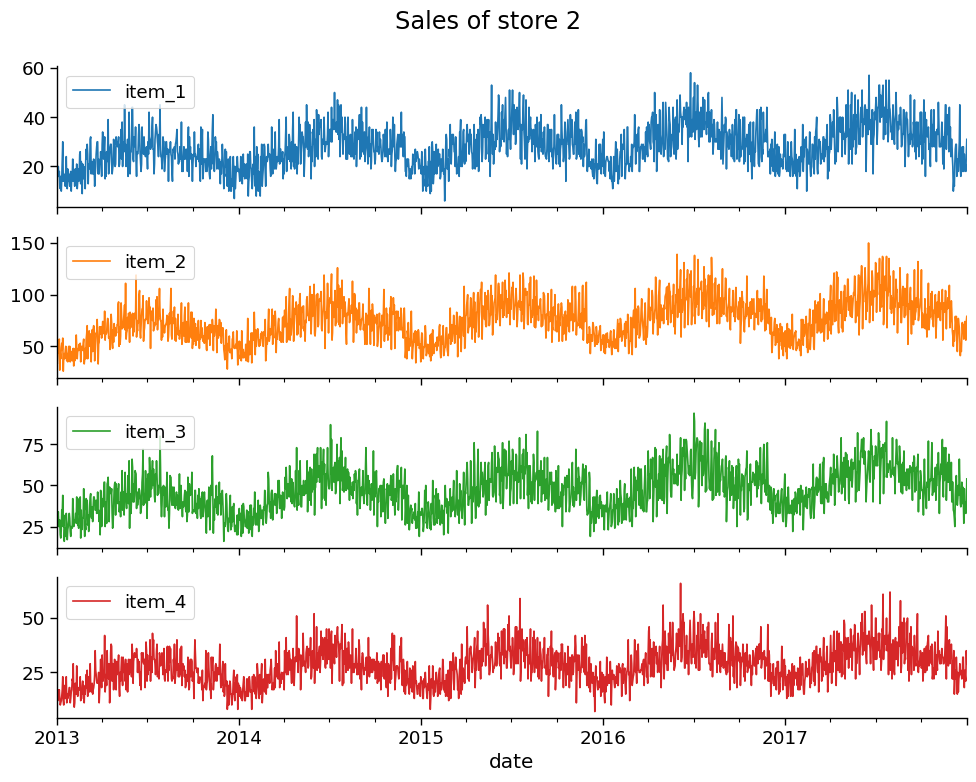

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title= f"Sales of store {selected_store}",
    ax=ax,
)

fig.tight_layout()

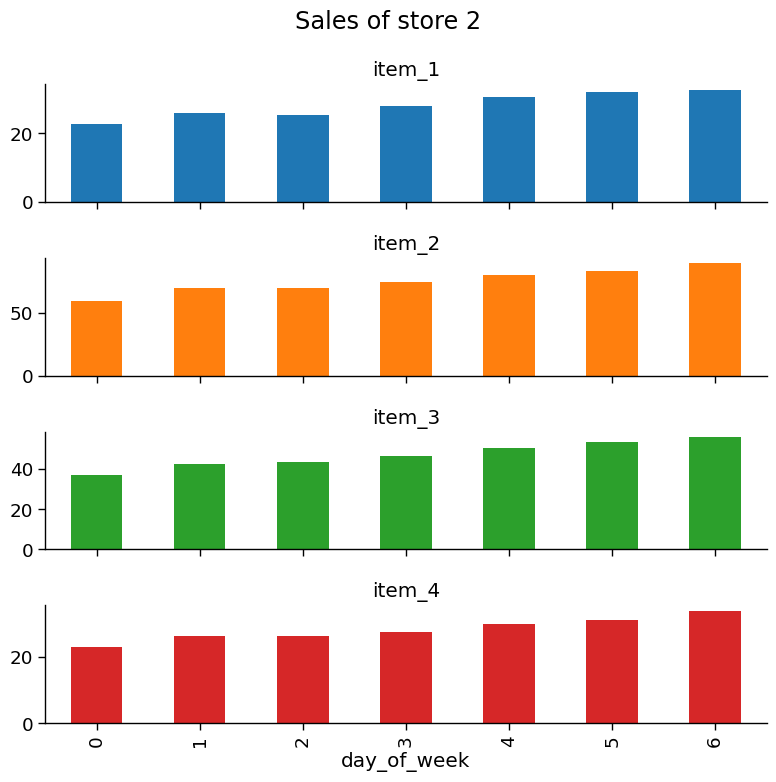

In [10]:
# Quick  plot to check for weekly seasonality
(
    data.assign(day_of_week=lambda x: data.index.weekday).groupby("day_of_week").mean()
).iloc[:, :4].plot(
    legend=False,
    subplots=True,
    sharex=True,
    title=f"Sales of store {selected_store}",
    kind="bar",
    figsize=(8,8)
)

plt.tight_layout()

In [11]:
# We're going to add the day of week to se as an exogenous feature
data["day_of_week"] = data.index.weekday
data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000,1
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000,2
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000,3
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000,4
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000,2
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000,3
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000,4


## 2) Local Forecasting

In [12]:
name_predictors = [f"lag_{i}" for i in range(1, 8)] + [
    "mean_7",
    "std_7",
    "mean_30",
    "std_30",
]
name_predictors

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'mean_7',
 'std_7',
 'mean_30',
 'std_30']

### 2.1) QC

In [13]:
# REFERENCE: To create forecaster with only lag features and no window features
# forecaster = ForecasterAutoreg(
#                  regressor        = Ridge(alpha=1),
#                  lags             = 7
#                  transformer_y    = StandardScaler(),
#                  transformer_exog = StandardScaler(),
#              )

# Create forecaster
forecaster = ForecasterAutoregCustom(
    regressor=Ridge(alpha=1),
    fun_predictors=create_predictors,
    name_predictors=name_predictors,
    window_size=30,  # Largest window size needed by `create_predictors`
    transformer_y=StandardScaler(),
    transformer_exog=StandardScaler(),
)

In [14]:
# QC: Let's see which are the X and y inputs before training
time_series_1 = data["item_1"]
X_train, y_train = forecaster.create_train_X_y(y=time_series_1)
display(X_train.head(), y_train.head())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,mean_7,std_7,mean_30,std_30
date,,,,,,,,,,,
2013-01-31,-2.0941,-1.1723,-1.5179,-1.8636,-1.6332,-1.2875,-1.6332,-1.6002,0.2935,-1.4411,0.4928
2013-02-01,-1.4027,-2.0941,-1.1723,-1.5179,-1.8636,-1.6332,-1.2875,-1.5673,0.3008,-1.4258,0.4865
2013-02-02,-1.4027,-1.4027,-2.0941,-1.1723,-1.5179,-1.8636,-1.6332,-1.5838,0.2879,-1.4258,0.4865
2013-02-03,-0.5961,-1.4027,-1.4027,-2.0941,-1.1723,-1.5179,-1.8636,-1.4356,0.4472,-1.3989,0.5088
2013-02-04,-1.6332,-0.5961,-1.4027,-1.4027,-2.0941,-1.1723,-1.5179,-1.4027,0.4222,-1.4219,0.5032


date
2013-01-31   -1.4027
2013-02-01   -1.4027
2013-02-02   -0.5961
2013-02-03   -1.6332
2013-02-04   -1.1723
Freq: D, Name: y, dtype: float64

### 2.2) Prepare Exogenous features

In [15]:
# Target time series column names
target_cols = data.filter(like="item_").columns
target_cols

Index(['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7',
       'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13',
       'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19',
       'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25',
       'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31',
       'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37',
       'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43',
       'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49',
       'item_50'],
      dtype='object')

In [16]:
# Exogenous feature column names
exog_cols = ["day_of_week"]
# Forecast horizon: Number of steps to predict
HORIZON = 14

In [17]:
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=HORIZON)

future_dates

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14'],
              dtype='datetime64[ns]', freq='D')

In [18]:
# Prepare exogenous features for the future
future_exog = pd.DataFrame(index=future_dates)
future_exog["day_of_week"] = future_exog.index.weekday
future_exog

,day_of_week
2018-01-01,0
2018-01-02,1
2018-01-03,2
2018-01-04,3
2018-01-05,4
2018-01-06,5
2018-01-07,6
2018-01-08,0
2018-01-09,1
2018-01-10,2


### 2.3) Linear-model: Ridge

In [19]:
# Prepare containers to store predictions
models = {}
predictions = {}

# Train a model and make a forecast for each time series
for item in target_cols:
    # Create forecaster
    forecaster = ForecasterAutoregCustom(
        regressor=Ridge(alpha=1),
        fun_predictors=create_predictors,
        name_predictors=name_predictors,
        window_size=30,  # Largest window size needed by `create_predictors`
        transformer_y=StandardScaler(),
        transformer_exog=StandardScaler(),
    )
    # Fit model
    forecaster.fit(y=data[item], exog=data[exog_cols])
    y_pred = forecaster.predict(steps=HORIZON, exog=future_exog)
    models[item] = forecaster
    predictions[item] = y_pred

# Results
forecast = pd.DataFrame(predictions)
forecast

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2018-01-01,17.8334,53.1837,31.1139,20.7718,16.0027,49.2661,51.6768,72.9051,41.2803,59.3627,61.1015,62.3651,73.7692,48.8737,76.3207,18.7190,25.9581,69.7916,32.7796,39.4145,36.0060,68.5590,25.6301,52.5500,71.3468,41.7146,19.8933,78.6567,59.9581,35.9080,51.6533,41.2004,56.6950,21.3080,54.5277,70.3910,25.0665,70.9853,37.3770,26.5879,17.8597,33.9015,45.8668,25.3112,75.3972,52.1527,20.4293,41.8384,25.9000,54.4891
2018-01-02,19.4081,58.7674,35.4600,22.3037,17.0008,52.2815,56.0461,82.1800,48.4937,67.8388,69.1165,68.5320,81.8451,53.8779,81.9974,21.5019,29.8033,76.7722,36.1965,43.0161,37.9722,79.8891,28.7607,58.5864,82.1637,47.2086,21.0208,85.9772,66.2494,37.2726,56.0924,46.3467,62.7664,22.7793,59.7904,78.8214,26.9235,82.5376,40.0975,28.7603,19.6630,37.0537,50.2219,26.9734,86.0307,57.8463,21.5373,44.9807,29.4017,58.4275
2018-01-03,20.2502,62.1165,36.2023,23.6108,18.4960,55.8769,59.8795,84.0136,50.5975,71.0377,72.4429,71.5544,83.9105,57.1183,88.5144,22.6722,30.6154,81.0132,38.3627,46.5172,39.1105,82.9146,30.4673,62.2772,87.3078,48.7284,22.3574,89.7422,69.0997,40.4597,59.8326,48.3490,63.1387,24.3032,61.6683,81.5113,28.0891,85.7529,40.7696,30.1761,21.8122,39.3829,52.8713,28.4231,89.9408,61.1197,22.5266,47.9815,29.9833,64.3861
2018-01-04,22.2000,65.6564,38.8072,25.0553,19.8749,60.5977,63.6381,91.7955,55.1205,76.2558,78.3481,77.0316,93.5386,62.3345,93.5316,24.2917,34.0221,86.6633,41.7011,49.9248,42.7987,88.8756,33.1909,67.6291,92.0756,53.0547,24.9216,98.3682,76.0889,43.9621,62.0613,51.4927,70.3652,26.3131,66.1805,87.7031,30.3978,94.2471,46.2470,32.4701,23.6510,42.5955,58.0171,30.5515,93.6545,66.2777,24.2612,51.7123,32.2657,67.9307
2018-01-05,24.5606,68.2083,41.9585,26.3310,21.8064,65.7100,67.9395,97.8454,58.6681,82.9766,86.3133,81.8724,99.5584,67.4144,101.6442,27.1467,36.5529,92.8462,45.8317,54.0203,47.0619,97.0066,34.8777,73.2782,99.1327,57.8798,26.1956,103.7628,82.0593,46.4764,67.9933,55.1660,74.1121,28.6517,74.0084,93.5323,32.4014,100.8905,49.3599,35.5102,25.7502,46.2626,61.6861,33.1900,99.1513,72.2330,26.4246,58.1779,34.7135,72.7593
2018-01-06,26.8581,74.6735,46.5729,29.1966,23.4125,69.7410,73.3421,104.2437,63.4252,88.0031,90.1997,89.8974,106.7442,69.9371,109.1389,29.6104,40.9269,99.3893,48.5774,58.1606,49.4551,104.3693,37.1613,79.1737,106.8460,61.4438,28.8403,112.3632,87.6703,50.2357,71.6129,58.9419,83.1791,30.9026,79.5819,100.4036,34.7995,105.3778,53.9528,37.1290,27.1072,48.3809,67.0773,36.0201,107.9356,75.4437,28.1427,62.6432,37.6570,79.3796
2018-01-07,28.4683,80.2893,50.8511,30.9068,25.4771,74.7828,78.6785,113.7489,69.1913,98.9616,98.6831,93.9380,114.9698,78.0148,118.8711,32.1005,44.8486,107.9164,52.9502,62.2520,52.8712,113.3200,39.9478,86.6559,115.5361,66.6492,30.5587,118.3988,94.3873,53.6060,78.5032,63.2969,89.3141,34.5246,84.2912,107.8894,37.9720,114.7384,56.6899,40.4906,29.7553,52.1615,72.3735,39.1406,116.2368,81.0119,30.4654,66.8349,41.2988,85.5075
2018-01-08,18.4108,51.9846,32.3978,21.0787,15.5039,48.9839,51.2708,74.6968,43.2270,60.4969,62.6125,62.9353,73.7417,50.0778,77.1379,19.8081,27.7380,69.2055,33.4295,40.8115,35.2073,71.8392,25.9213,55.0386,73.3492,42.3178,20.2135,77.9064,60.9967,35.0678,51.9212,41.9732,56.6499,22.3071,53.8091,71.6215,24.9690,74.0899,36.3430,26.0841,19.2477,34.1446,46.9992,25.2892,76.5872,53.6230,20.3856,42.9988,26.3730,55.3849
2018-01-09,20.0405,58.0306,35.7631,22.8465,17.4716,54.3447,56.6501,82.0885,49.5156,68.1452,69.4948,68.9398,82.4822,55.5547,85.4426,22.8206,31.0509,77.6056,37.6831,45.1708,38.8011,80.8303,28.6536,61.3334,83.0947,47.1966,22.0498,86.7850,67.6954,39.0328,56.8287,46.5191,63.2764,24.7686,60.8082,79.7516

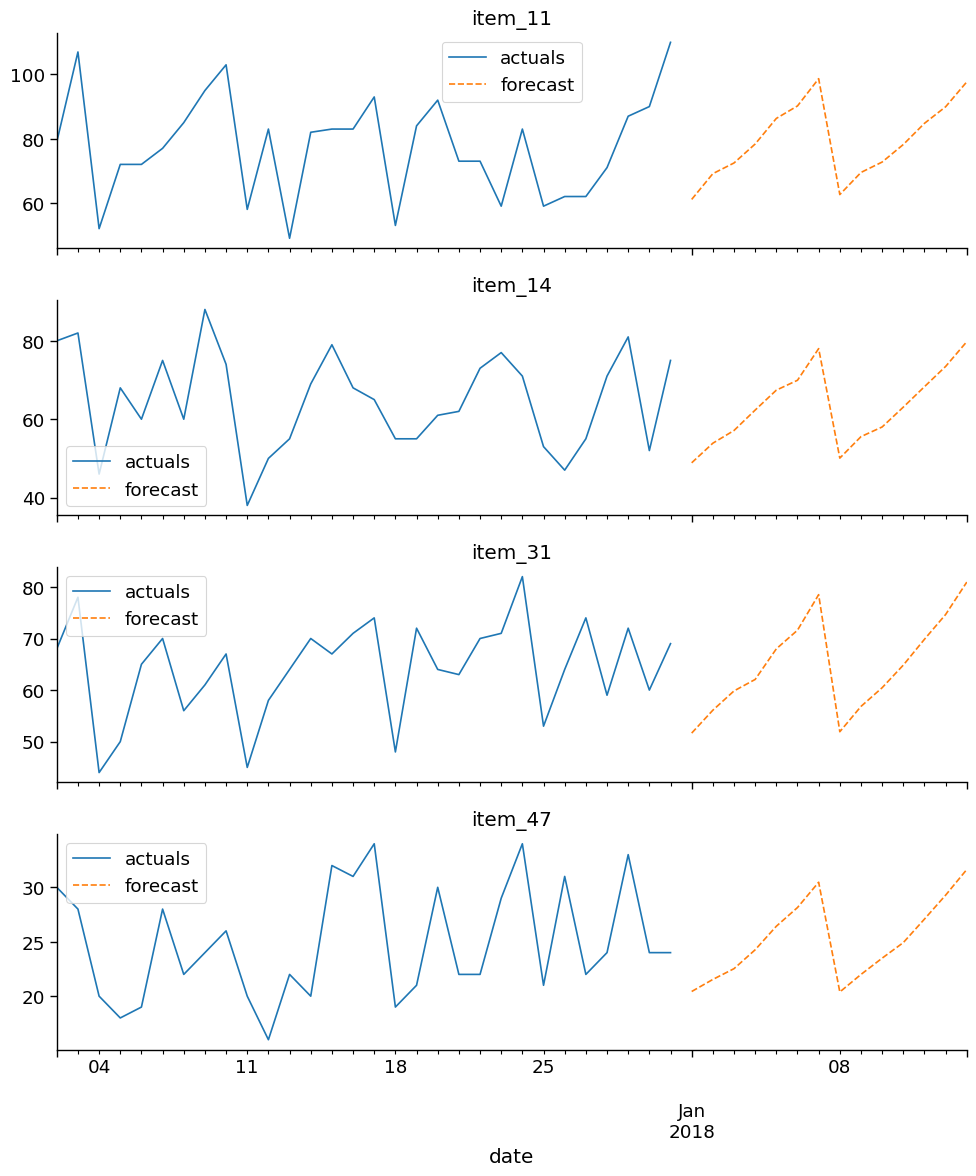

In [22]:
# Select a random subsample of timeseries
num_timeseries = 4
data_subset = data[target_cols].sample(n=num_timeseries, axis=1, random_state=123)

# Plotting Forecast
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries], sharex=True)
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]
    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

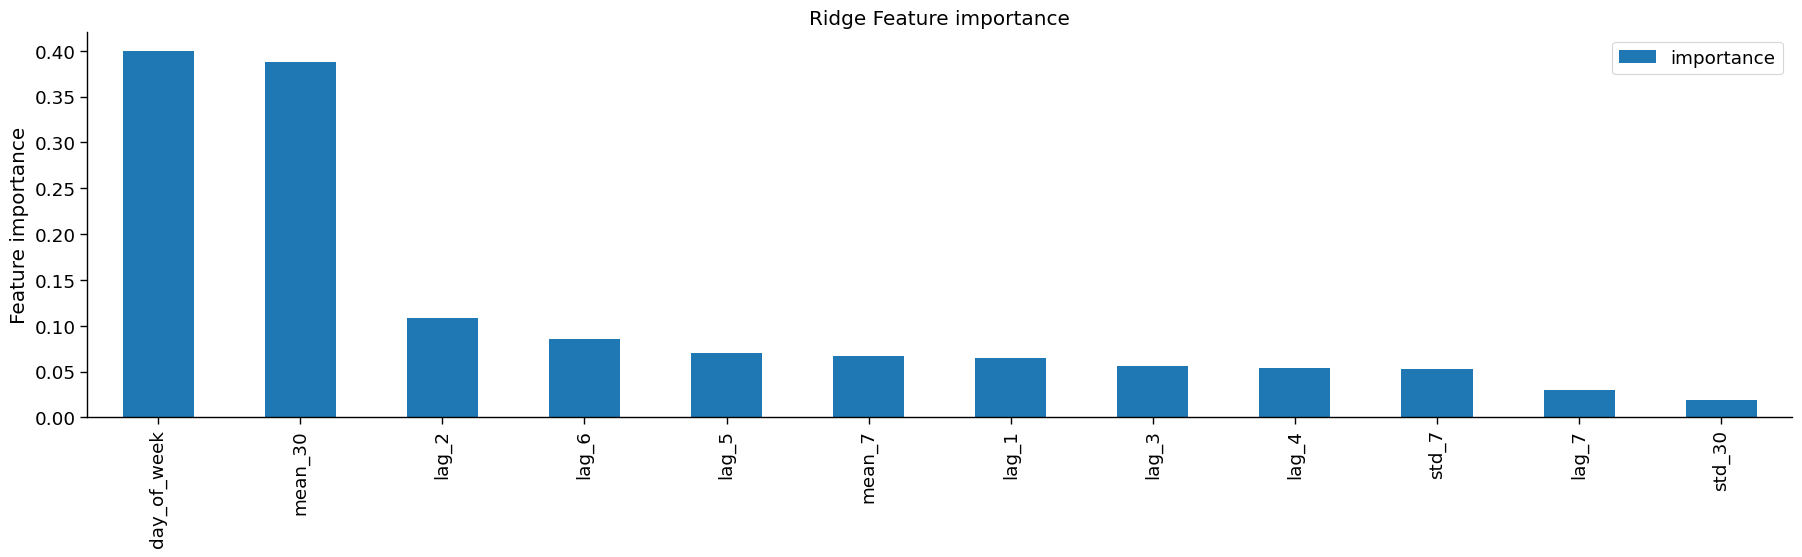

In [30]:
(
    models["item_1"]
    .get_feature_importances()
    .sort_values("importance", ascending=False)
    .set_index("feature")
    .plot(kind="bar")
)

plt.title("Ridge Feature importance")
plt.ylabel("Feature importance")
plt.xlabel("")
plt.show()

### 2.4) Tree-model: Random Forest

In [31]:
# Prepare containers to store predictions
models = {}
predictions = {}

# Train a model and make a forecast for each time series
for item in target_cols:
    # Create forecaster
    forecaster = ForecasterAutoregCustom(
        regressor=RandomForestRegressor(),
        fun_predictors=create_predictors,
        name_predictors=name_predictors,
        window_size=30,  # Largest window size needed by `create_predictors`
        transformer_y=StandardScaler(),
        transformer_exog=StandardScaler(),
    )
    # Fit model
    forecaster.fit(y=data[item], exog=data[exog_cols])
    y_pred = forecaster.predict(steps=HORIZON, exog=future_exog)
    models[item] = forecaster
    predictions[item] = y_pred

# Results
forecast = pd.DataFrame(predictions)
forecast

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2018-01-01,19.6400,54.5400,35.7800,19.9200,15.9100,48.0100,53.4800,73.5300,43.3700,65.4700,61.4800,69.1700,72.4200,51.2100,79.3500,20.4200,25.7100,70.3400,31.2800,43.2600,35.4400,67.2000,23.7100,56.0200,68.2800,40.2400,19.9500,81.1100,61.4400,35.4300,53.6400,40.1200,58.5000,18.7700,51.9500,71.4600,27.0700,77.4300,39.1200,28.2700,18.9300,35.1200,43.5700,26.7700,81.3600,55.6000,22.3200,44.1400,24.4800,54.1900
2018-01-02,21.4100,61.0700,40.0000,24.5900,17.5400,59.1600,62.5000,85.3300,52.3100,69.0800,75.3600,73.5200,85.3700,63.3100,86.2800,23.1100,28.0900,79.2000,39.9600,48.6900,40.8500,80.9300,31.4000,62.1400,83.4700,52.2900,21.8800,88.4600,70.4400,37.8700,62.7600,47.4200,75.6000,22.5600,62.8700,80.8500,27.8200,85.9900,44.3600,30.5300,22.9300,39.6800,51.4900,30.0000,89.8700,59.5600,22.0000,51.7200,32.0200,62.6800
2018-01-03,22.8600,63.8700,36.3500,22.5300,18.4600,57.5800,62.8800,87.8000,53.5800,74.0200,74.4200,76.1300,90.9800,64.3700,97.2300,24.3300,27.1700,86.5200,39.0800,51.0200,41.8000,81.2500,32.0600,63.2500,96.9300,50.9400,21.5200,93.0600,69.1100,38.9900,64.7200,47.5600,68.7300,23.4900,66.0900,88.0500,27.6500,89.9900,43.5200,31.2900,19.1600,41.4400,48.3800,27.9200,91.3400,63.4600,23.6000,52.8700,30.3000,69.0600
2018-01-04,21.6000,65.0500,36.8600,22.6000,18.4600,61.4600,66.6000,97.6200,54.8000,79.6500,81.2200,84.1200,100.6200,68.8100,99.5000,23.9500,29.0900,88.5500,45.2800,52.0900,45.4400,91.5500,34.2100,67.3900,93.1200,58.9900,23.7700,105.6500,76.7300,41.5600,58.5100,55.9300,69.6000,26.1600,69.9500,94.7400,30.4900,89.8600,43.5400,31.6700,23.2900,43.8300,53.3200,31.4300,96.7300,67.5400,23.9000,51.0200,29.6800,66.4900
2018-01-05,23.3700,65.9600,43.6800,25.3900,21.4400,67.2300,71.2900,101.7700,64.9500,82.0300,86.5700,82.2400,108.1900,76.2100,105.7800,30.0500,36.8300,93.9100,47.8800,53.7800,50.3100,96.9000,36.1200,75.0800,100.4400,60.4400,24.7400,109.5300,82.9700,48.7100,71.0100,53.9100,72.6800,28.4300,80.2800,97.7000,32.4800,97.5900,47.2800,35.9500,25.5000,47.6500,59.2500,31.3000,103.3500,68.5800,29.0300,58.4800,34.0000,66.1600
2018-01-06,25.0400,72.5000,44.4400,28.8900,24.9600,68.8400,76.8100,107.5100,66.6400,90.3900,93.9000,88.0400,105.4100,65.6500,105.2700,29.2900,40.2000,93.6500,46.8800,58.1200,51.5700,106.9200,38.8500,79.2000,109.6700,63.1700,26.8000,118.9200,86.7600,52.5000,72.6400,61.1300,79.6800,29.4600,79.6800,101.0200,34.0700,102.7500,55.0100,38.0400,29.6800,50.1300,61.8000,35.2000,108.7900,70.0200,28.6900,65.3000,35.7100,76.6700
2018-01-07,27.7600,80.9900,46.2000,30.9600,22.4300,70.1600,77.2100,117.0300,67.9300,102.0000,99.8100,96.0500,112.7400,78.1700,110.2400,29.6600,38.3800,94.1800,49.3200,58.6200,51.2800,119.6100,36.9000,80.3900,109.3700,68.3000,26.8900,117.2700,92.7600,51.4700,77.2200,62.8000,80.0500,30.2000,71.1300,102.2800,34.5200,112.2400,55.3900,40.9400,30.8300,54.7700,69.4400,37.1800,115.4900,76.0800,31.1900,67.6700,40.4300,76.7100
2018-01-08,19.6200,54.3100,34.8400,18.9800,18.3100,48.4000,53.4100,76.4800,45.0300,67.7000,63.1800,70.0100,76.1100,52.8600,73.9400,20.5900,26.7300,67.0900,34.2800,46.4800,35.9600,73.5300,25.4100,57.1100,71.4100,43.5800,18.6100,85.1000,58.2000,32.7000,53.6000,40.2700,59.7700,21.8300,53.4200,72.9900,25.1700,77.2000,36.1000,28.8700,19.0100,36.7100,43.6100,31.8900,80.2600,58.2400,23.6300,41.7600,23.8200,49.8200
2018-01-09,22.0100,61.1800,39.7200,21.7100,18.0900,64.0100,62.2900,85.8300,55.0300,72.2600,77.8300,74.4500,84.8400,58.5800,88.8200,24.6400,30.7900,81.4200,37.5300,52.5600,45.0400,88.0100,31.1500,63.7500,86.0000,53.8400,22.0900,94.7800,69.9500,38.0200,62.1300,48.4800,70.6100,24.8600,61.5500,81

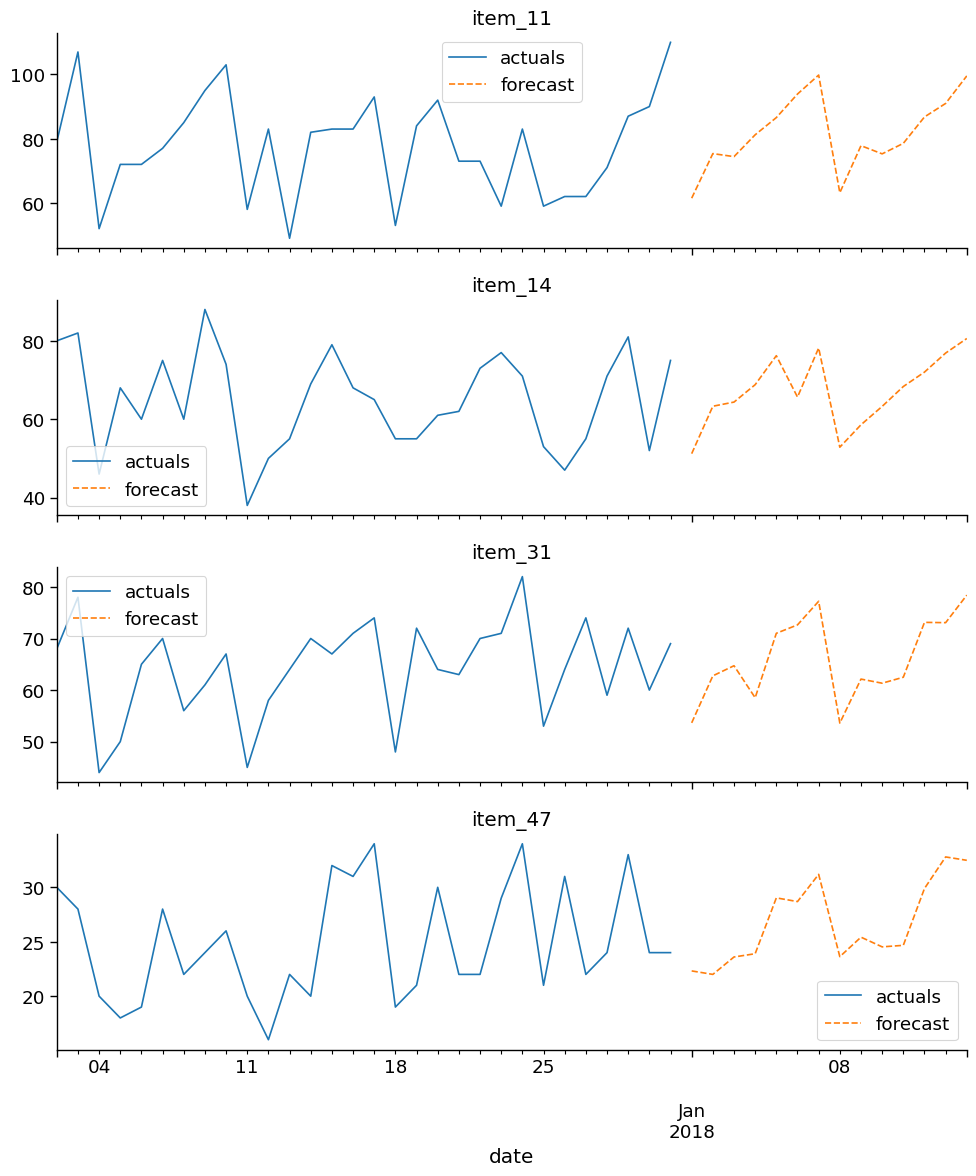

In [32]:
# Select a random subsample of timeseries
num_timeseries = 4
data_subset = data[target_cols].sample(n=num_timeseries, axis=1, random_state=123)

# Plotting Forecast
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries], sharex=True)
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]
    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

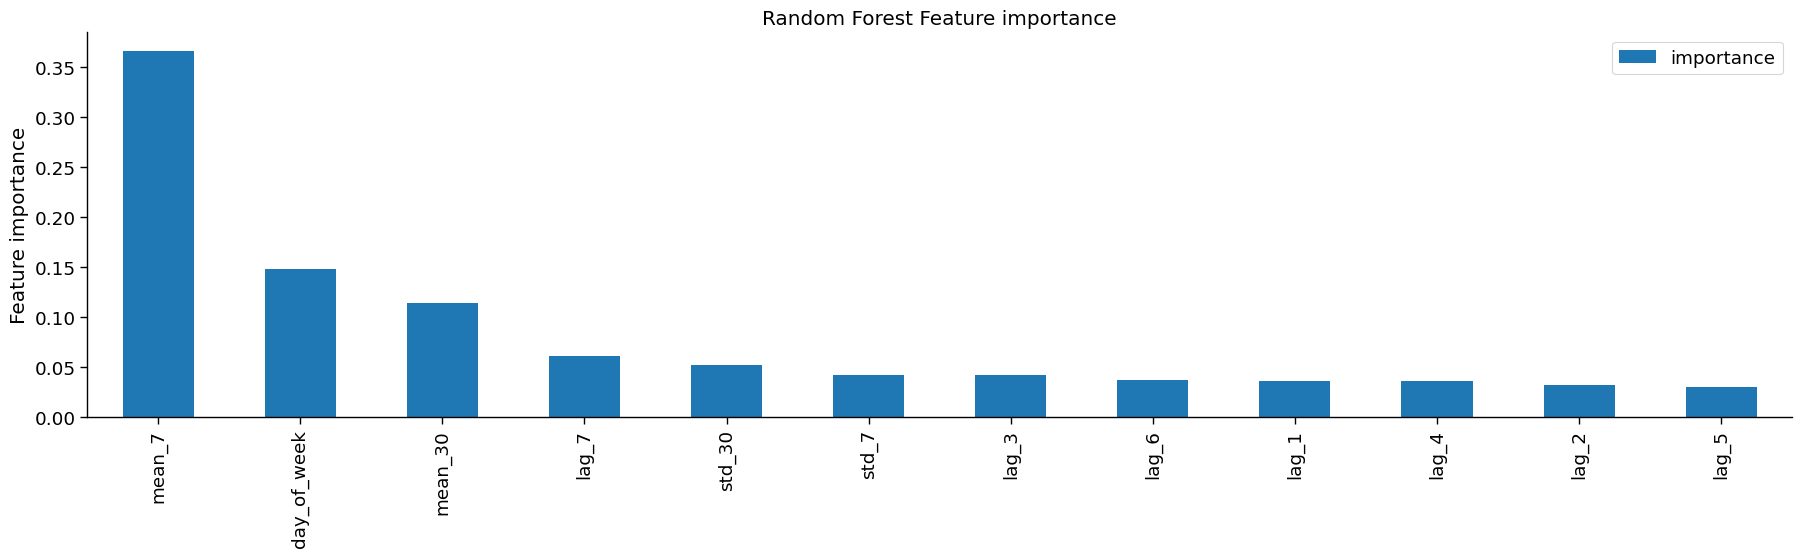

In [33]:
(
    models["item_1"]
    .get_feature_importances()
    .sort_values("importance", ascending=False)
    .set_index("feature")
    .plot(kind="bar")
)

plt.title("Random Forest Feature importance")
plt.ylabel("Feature importance")
plt.xlabel("")
plt.show()